CUSTOMER LIFECYCLE


Recency (R): Days since last purchase.
Lower values = more engaged customers.

Tenure Days (T): Total days as a customer.
Higher values = longer relationship.
Combining these reveals customer lifecycle patterns:

New customers (Low T) with high recency (High R) → At risk of churning early.

Loyal customers (High T) with low recency (Low R) → Highly valuable.

Long-tenured but inactive (High T + High R) → Need re-engagement.

In [1]:
import pandas as pd
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from enum import unique
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score

import os

df = pd.read_csv('featured_customer_segmentation.csv',dtype={'Lifecycle_Group': str})
# Calculate key ratios
df['Engagement_Ratio'] = df['Tenure_Days'] / (df['Recency'] + 1e-6)  # Avoid division by zero
df['Activity_Index'] = (1 / df['Recency']) * df['Tenure_Days']  # Weighted activity

# Binning for RFM-style segments
df['Recency_Score'] = pd.qcut(df['Recency'], q=5, labels=[5, 4, 3, 2, 1])  # Lower recency = higher score
df['Tenure_Score'] = pd.qcut(df['Tenure_Days'], q=5, labels=[1, 2, 3, 4, 5])  # Higher tenure = higher score
df['Lifecycle_Group'] = df['Recency_Score'].astype(str) + '-' + df['Tenure_Score'].astype(str)



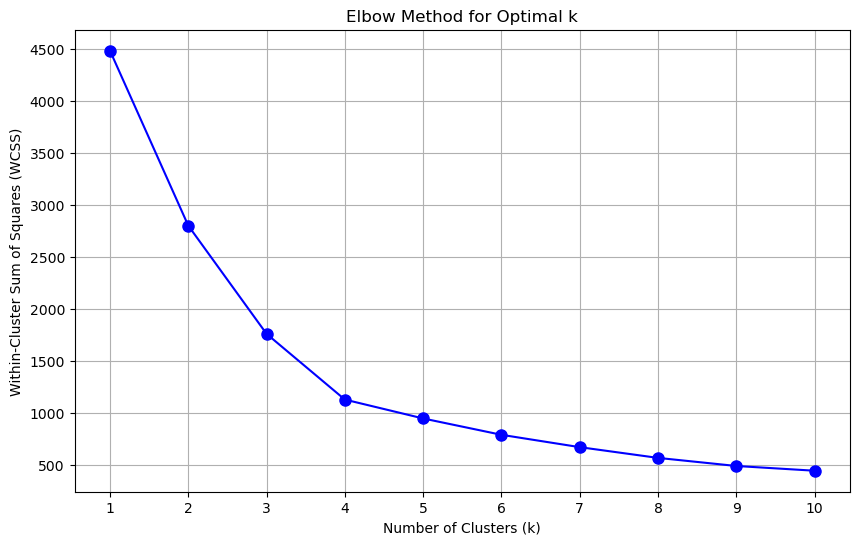

In [2]:


# Prepare data (assuming X_scaled is already defined)
X = df[['Recency', 'Tenure_Days']]  # Or your selected features
X_scaled = StandardScaler().fit_transform(X)

# Calculate WCSS for k values from 1 to 10
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # Inertia = Within-Cluster Sum of Squares

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-', markersize=8)
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.grid(True)
plt.xticks(k_range)
plt.show()

# Optional: Automate elbow detection (example)
# Calculate the difference in slopes
diffs = [wcss[i-1] - wcss[i] for i in range(1, len(wcss))]
elbow_index = diffs.index(max(diffs)) + 1  # +1 because index starts at k=2
optimal_k = elbow_index + 1  # Add 1 since indexing starts from 0

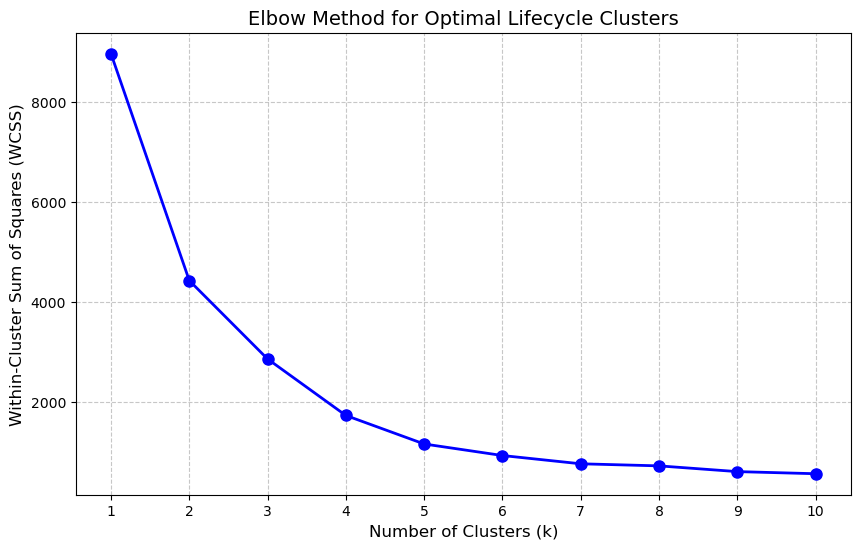

In [3]:


# 1. Calculate key ratios with safeguards
df['Engagement_Ratio'] = np.where(
    df['Recency'] == 0,
    df['Tenure_Days'] * 1000,  # Custom high value for Recency=0
    df['Tenure_Days'] / df['Recency']
)

df['Activity_Index'] = np.where(
    df['Recency'] == 0,
    df['Tenure_Days'] * 1000,  # Custom high value for Recency=0
    df['Tenure_Days'] / df['Recency']
)

# 2. Cap extreme values (99.5th percentile)
for col in ['Engagement_Ratio', 'Activity_Index']:
    upper_cap = df[col].quantile(0.995)
    df[col] = np.where(df[col] > upper_cap, upper_cap, df[col])

# 3. Binning with duplicate handling
try:
    df['Recency_Score'] = pd.qcut(df['Recency'], q=5, labels=[5, 4, 3, 2, 1], duplicates='drop')
    df['Tenure_Score'] = pd.qcut(df['Tenure_Days'], q=5, labels=[1, 2, 3, 4, 5], duplicates='drop')
except ValueError:
    # Fallback to equal-width binning if quantile binning fails
    df['Recency_Score'] = pd.cut(df['Recency'], bins=5, labels=[5, 4, 3, 2, 1])
    df['Tenure_Score'] = pd.cut(df['Tenure_Days'], bins=5, labels=[1, 2, 3, 4, 5])

# 4. Handle any remaining NaN values
df['Recency_Score'] = df['Recency_Score'].fillna(df['Recency_Score'].mode()[0])
df['Tenure_Score'] = df['Tenure_Score'].fillna(df['Tenure_Score'].mode()[0])

# 5. Convert to integer types
df['Recency_Score'] = df['Recency_Score'].astype(int)
df['Tenure_Score'] = df['Tenure_Score'].astype(int)

# 6. Prepare features for clustering
X = df[['Engagement_Ratio', 'Activity_Index', 'Recency_Score', 'Tenure_Score']]

# 7. Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 8. Elbow Method to find optimal clusters
wcss = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, 'bo-', markersize=8, linewidth=2)
plt.title('Elbow Method for Optimal Lifecycle Clusters', fontsize=14)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Within-Cluster Sum of Squares (WCSS)', fontsize=12)
plt.grid(linestyle='--', alpha=0.7)
plt.xticks(k_range)
plt.show()

NUMBER OF CUSTOMERS IN EACH SEGMENT

From the above elbow method,we were able to get k=3 therefore 3 clusters. Below 
we are obtaining the number of customers in each cluster

In [4]:
# Fit K-Means with optimal clusters (k=3)
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
cluster_labels = kmeans.fit_predict(X_scaled)

# Add cluster labels to DataFrame
df['Lifecycle_Group'] = cluster_labels  # Store cluster assignments

# Count customers per cluster
cluster_counts = df['Lifecycle_Group'].value_counts().sort_index()
print("\nCustomer Count per Cluster:")
print(cluster_counts)

# Percentage distribution
cluster_percent = cluster_counts / len(df) * 100
print("\nPercentage Distribution:")
print(cluster_percent.map('{:.1f}%'.format))


Customer Count per Cluster:
Lifecycle_Group
0    1173
1      28
2    1039
Name: count, dtype: int64

Percentage Distribution:
Lifecycle_Group
0    52.4%
1     1.2%
2    46.4%
Name: count, dtype: object


In [ ]:

# Generate cluster profile
cluster_profile = df.groupby('Lifecycle_Group').agg({
    'Recency': ['mean', 'median'],
    'Tenure_Days': ['mean', 'median'],
    'Engagement_Ratio': 'median',
    'Activity_Index': 'median',
    'ID': 'count'
}).reset_index()

# Calculate percentage of total customers
cluster_profile['%_of_Customers'] = (cluster_profile[('ID', 'count')] / len(df)) * 100

# Add business interpretation
cluster_profile['Lifecycle_Stage'] = cluster_profile.apply(
    lambda row: "Churned" if row[('Recency', 'mean')] > 90 
    else "At-Risk" if row[('Recency', 'mean')] > 60 
    else "Loyal" if row[('Tenure_Days', 'mean')] > 365 
    else "New", axis=1
)

# Format column names for readability
cluster_profile.columns = [
    'Cluster',
    'Avg_Recency', 'Median_Recency',
    'Avg_Tenure', 'Median_Tenure',
    'Med_Engagement',
    'Med_Activity',
    'Customer_Count',
    '%_of_Base',
    'Lifecycle_Stage'
]

# Print the cluster profiles with descriptions
print("\nCluster Profiles with Business Interpretation:")
print(cluster_profile[['Cluster', 'Lifecycle_Stage', 'Customer_Count', '%_of_Base', 
                       'Avg_Recency', 'Avg_Tenure', 'Med_Engagement', 'Med_Activity']])

from tabulate import tabulate

# Format numeric values for display
formatted_profile = cluster_profile.copy()
formatted_profile['%_of_Base'] = formatted_profile['%_of_Base'].map('{:.2f}%'.format)
formatted_profile['Avg_Recency'] = formatted_profile['Avg_Recency'].map('{:.1f}'.format)
formatted_profile['Avg_Tenure'] = formatted_profile['Avg_Tenure'].map('{:.1f}'.format)
formatted_profile['Med_Engagement'] = formatted_profile['Med_Engagement'].map('{:.3f}'.format)
formatted_profile['Med_Activity'] = formatted_profile['Med_Activity'].map('{:.3f}'.format)

# Print formatted table
print("\nFormatted Cluster Profiles:")
print(tabulate(
    formatted_profile[['Cluster', 'Lifecycle_Stage', 'Customer_Count', '%_of_Base',
                       'Avg_Recency', 'Avg_Tenure', 'Med_Engagement', 'Med_Activity']],
    headers=['Cluster', 'Lifecycle Stage', 'Customers', '% of Base', 
             'Avg Recency', 'Avg Tenure', 'Med Engagement', 'Med Activity'],
    tablefmt='pretty',
    showindex=False
))


Cluster Profiles with Business Interpretation:
   Cluster Lifecycle_Stage  Customer_Count  %_of_Base  Avg_Recency  \
0        0         At-Risk            1173  52.366071    60.663257   
1        1           Loyal              28   1.250000     0.000000   
2        2           Loyal            1039  46.383929    37.388835   

    Avg_Tenure  Med_Engagement  Med_Activity  
0  4531.011083    7.208197e+01  7.208197e+01  
1  4326.928571    4.301500e+06  4.301500e+06  
2  4240.225217    1.375312e+02  1.375312e+02  

Formatted Cluster Profiles:
+---------+-----------------+-----------+-----------+-------------+------------+----------------+--------------+
| Cluster | Lifecycle Stage | Customers | % of Base | Avg Recency | Avg Tenure | Med Engagement | Med Activity |
+---------+-----------------+-----------+-----------+-------------+------------+----------------+--------------+
|    0    |     At-Risk     |   1173    |  52.37%   |    60.7     |   4531.0   |     72.082     |    72.082    |
| 

From the above we saw that both cluster 1 and cluster 2 have similar life stages "Loyal".Now we had to to obtain another difference between the two clusters and found out that cluster 1 has extremely high engagement and activity (and recency=0) which might indicate highly active customers, while cluster 2 Avg_Recency: 37.4 -> less than 60, so not At-Risk or Churned
Avg_Tenure: 4237 days -> long tenure ,Med_Engagement and Med_Activity: 137.4 (high but not extreme)

In [6]:
# Step 1: Calculate thresholds
ENGAGEMENT_THRESHOLD = df['Engagement_Ratio'].quantile(0.85)
ACTIVITY_THRESHOLD = df['Activity_Index'].quantile(0.85)

# Step 2: Group and aggregate cluster profile (without renaming columns yet)
cluster_profile = df.groupby('Lifecycle_Group').agg({
    'Recency': ['mean', 'median'],
    'Tenure_Days': ['mean', 'median'],
    'Engagement_Ratio': 'median',
    'Activity_Index': 'median',
    'Total_Spending': 'sum',     # ← Add total spending here
    'ID': 'count'
}).reset_index()

# Step 3: Add percentage of customers
cluster_profile['%_of_Customers'] = (cluster_profile[('ID', 'count')] / len(df)) * 100

# Step 4: Business logic for lifecycle stages
cluster_profile['Lifecycle_Stage'] = cluster_profile.apply(
    lambda row: (
        "Churned" if row[('Recency', 'mean')] > 90 
        else "At-Risk" if row[('Recency', 'mean')] > 60 
        else "Super-Engaged" if (
            row[('Engagement_Ratio', 'median')] > ENGAGEMENT_THRESHOLD * 5 and 
            row[('Activity_Index', 'median')] > ACTIVITY_THRESHOLD * 5
        )
        else "Loyal-High-Value" if (
            row[('Engagement_Ratio', 'median')] > ENGAGEMENT_THRESHOLD and 
            row[('Activity_Index', 'median')] > ACTIVITY_THRESHOLD
        )
        else "Loyal-Regular" if row[('Tenure_Days', 'mean')] > 365 
        else "New"
    ), axis=1
)

# Step 5: Rename columns for clarity
cluster_profile.columns = [
    'Cluster',
    'Avg_Recency', 'Median_Recency',
    'Avg_Tenure', 'Median_Tenure',
    'Med_Engagement',
    'Med_Activity',
    'Total_Spending',             # ← New column added
    'Customer_Count',
    '%_of_Base',
    'Lifecycle_Stage'
]

# Step 6: Print profile summary
print("\nRefined Cluster Profiles:")
print(cluster_profile[['Cluster', 'Lifecycle_Stage', 'Customer_Count', 
                       'Avg_Recency', 'Med_Engagement', 'Med_Activity', 'Total_Spending']])



Refined Cluster Profiles:
   Cluster Lifecycle_Stage  Customer_Count  Avg_Recency  Med_Engagement  \
0        0         At-Risk            1173    60.663257    7.208197e+01   
1        1   Super-Engaged              28     0.000000    4.301500e+06   
2        2   Loyal-Regular            1039    37.388835    1.375312e+02   

   Med_Activity  Total_Spending  
0  7.208197e+01        737281.0  
1  4.301500e+06         11997.5  
2  1.375312e+02        523504.5  


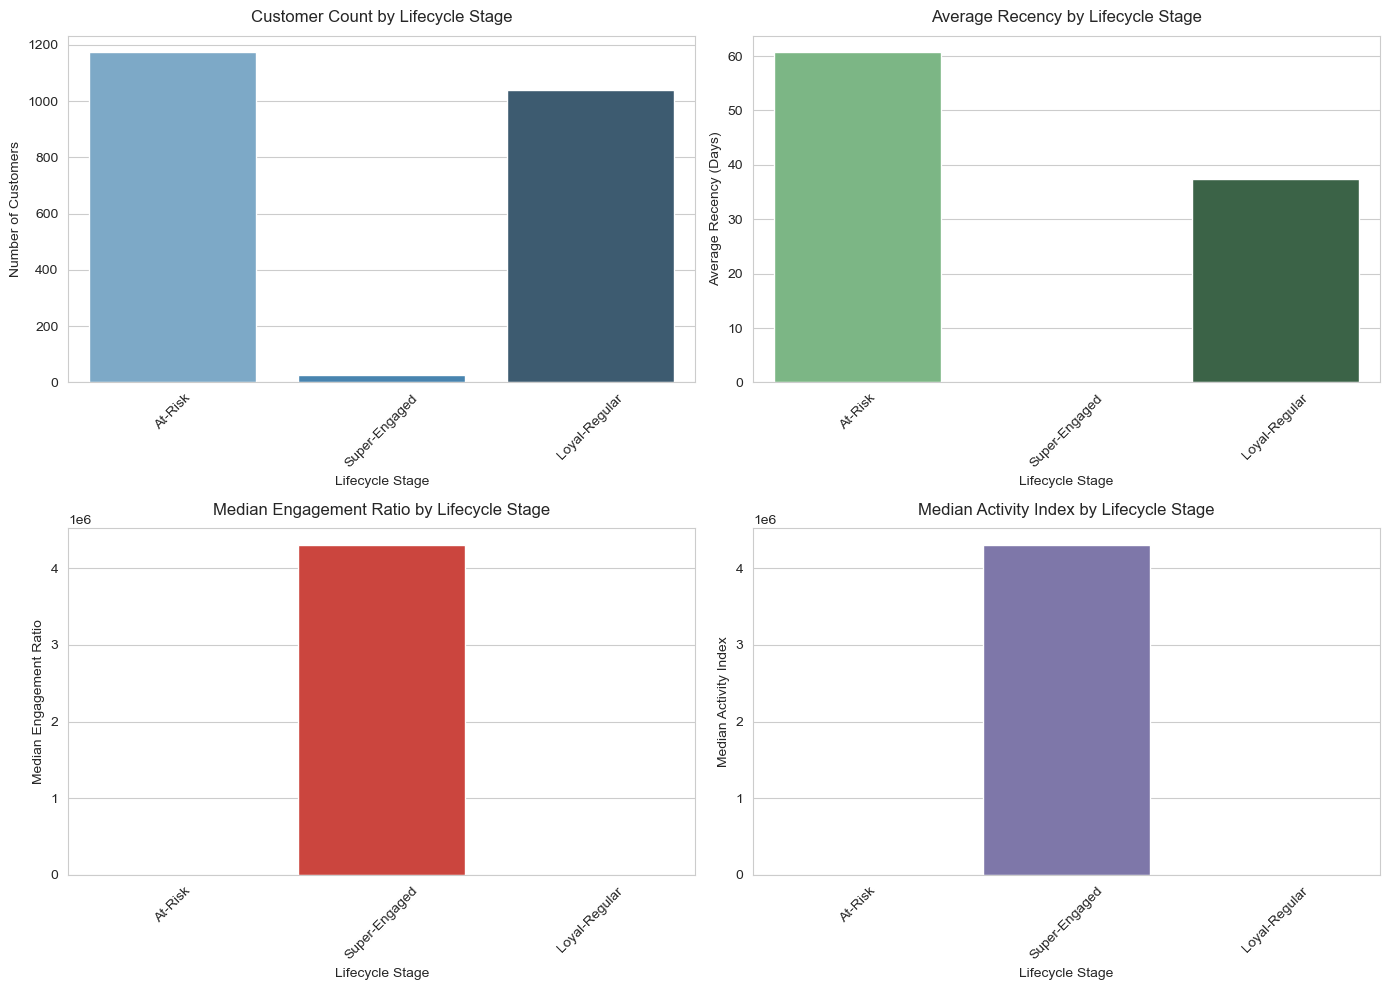

In [7]:

# Set seaborn style for better aesthetics
sns.set_style("whitegrid")

# Create a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=False)
axes = axes.flatten()  # Flatten the 2x2 array for easier indexing

# Bar graph for Customer Count by Lifecycle Stage
sns.barplot(x='Lifecycle_Stage', y='Customer_Count', hue='Lifecycle_Stage', data=cluster_profile, ax=axes[0], palette='Blues_d', legend=False)
axes[0].set_title('Customer Count by Lifecycle Stage', fontsize=12, pad=10)
axes[0].set_xlabel('Lifecycle Stage', fontsize=10)
axes[0].set_ylabel('Number of Customers', fontsize=10)
axes[0].tick_params(axis='x', rotation=45)

# Bar graph for Average Recency by Lifecycle Stage
sns.barplot(x='Lifecycle_Stage', y='Avg_Recency', hue='Lifecycle_Stage', data=cluster_profile, ax=axes[1], palette='Greens_d', legend=False)
axes[1].set_title('Average Recency by Lifecycle Stage', fontsize=12, pad=10)
axes[1].set_xlabel('Lifecycle Stage', fontsize=10)
axes[1].set_ylabel('Average Recency (Days)', fontsize=10)
axes[1].tick_params(axis='x', rotation=45)

# Bar graph for Median Engagement by Lifecycle Stage
sns.barplot(x='Lifecycle_Stage', y='Med_Engagement', hue='Lifecycle_Stage', data=cluster_profile, ax=axes[2], palette='Reds_d', legend=False)
axes[2].set_title('Median Engagement Ratio by Lifecycle Stage', fontsize=12, pad=10)
axes[2].set_xlabel('Lifecycle Stage', fontsize=10)
axes[2].set_ylabel('Median Engagement Ratio', fontsize=10)
axes[2].tick_params(axis='x', rotation=45)

# Bar graph for Median Activity by Lifecycle Stage
sns.barplot(x='Lifecycle_Stage', y='Med_Activity', hue='Lifecycle_Stage', data=cluster_profile, ax=axes[3], palette='Purples_d', legend=False)
axes[3].set_title('Median Activity Index by Lifecycle Stage', fontsize=12, pad=10)
axes[3].set_xlabel('Lifecycle Stage', fontsize=10)
axes[3].set_ylabel('Median Activity Index', fontsize=10)
axes[3].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plot
plt.show()

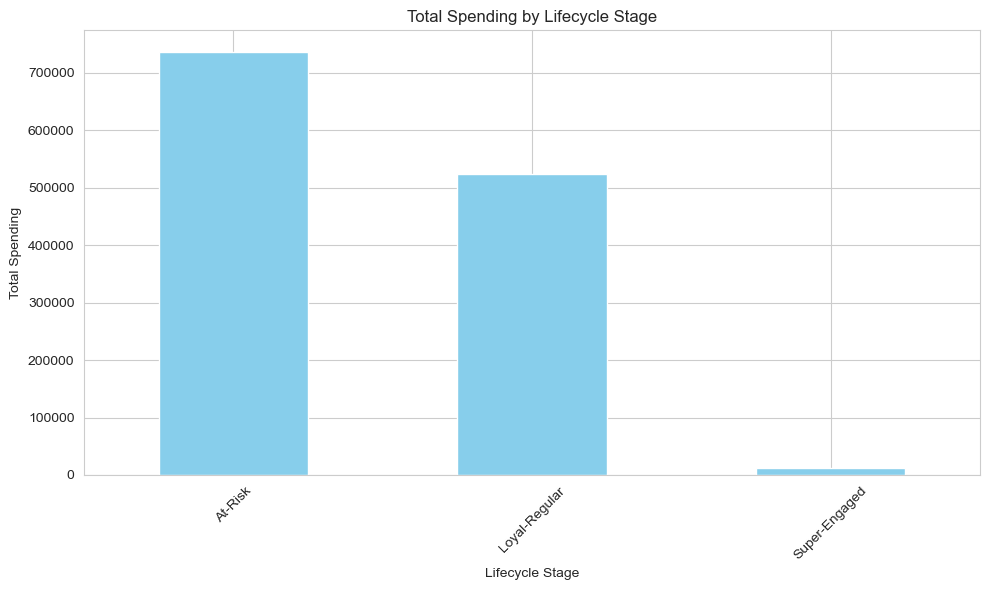

In [8]:
# Create a dictionary from cluster_profile
cluster_to_stage = dict(zip(cluster_profile['Cluster'], cluster_profile['Lifecycle_Stage']))

# Map lifecycle stage back to the main df
df['Lifecycle_Stage'] = df['Lifecycle_Group'].map(cluster_to_stage)
spending_by_stage = df.groupby('Lifecycle_Stage')['Total_Spending'].sum().sort_values(ascending=False)

plt.figure(figsize=(10, 6))
spending_by_stage.plot(kind='bar', color='skyblue')
plt.title('Total Spending by Lifecycle Stage')
plt.xlabel('Lifecycle Stage')
plt.ylabel('Total Spending')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [9]:

# Assuming df is your original dataset with features and Lifecycle_Stage
# Step 1: Add Lifecycle_Stage to df based on clustering logic
# Calculate thresholds
ENGAGEMENT_THRESHOLD = df['Engagement_Ratio'].quantile(0.85)
ACTIVITY_THRESHOLD = df['Activity_Index'].quantile(0.85)

# Assign Lifecycle_Stage to each row
df['Lifecycle_Stage'] = df.apply(
    lambda row: (
        "Churned" if row['Recency'] > 90 
        else "At-Risk" if row['Recency'] > 60 
        else "Super-Engaged" if (
            row['Engagement_Ratio'] > ENGAGEMENT_THRESHOLD * 5 and 
            row['Activity_Index'] > ACTIVITY_THRESHOLD * 5
        )
        else "Loyal-High-Value" if (
            row['Engagement_Ratio'] > ENGAGEMENT_THRESHOLD and 
            row['Activity_Index'] > ACTIVITY_THRESHOLD
        )
        else "Loyal-Regular" if row['Tenure_Days'] > 365 
        else "New"
    ), axis=1
)

#Prepare features and target
features = ['Recency', 'Tenure_Days', 'Engagement_Ratio', 'Activity_Index', 'Total_Spending']
X = df[features]
y = df['Lifecycle_Stage']

# Encode the target variable (Lifecycle_Stage) to numeric values
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 3: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Initialize and train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
print("\nModel Performance:")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:")
print(feature_importance)


Model Performance:
Classification Report:
                  precision    recall  f1-score   support

         At-Risk       1.00      1.00      1.00       133
         Churned       1.00      1.00      1.00        39
Loyal-High-Value       1.00      1.00      1.00        51
   Loyal-Regular       1.00      1.00      1.00       209
   Super-Engaged       1.00      1.00      1.00        16

        accuracy                           1.00       448
       macro avg       1.00      1.00      1.00       448
    weighted avg       1.00      1.00      1.00       448


Confusion Matrix:
[[133   0   0   0   0]
 [  0  39   0   0   0]
 [  0   0  51   0   0]
 [  0   0   0 209   0]
 [  0   0   0   0  16]]

Feature Importance:
            Feature  Importance
0           Recency    0.418814
3    Activity_Index    0.285875
2  Engagement_Ratio    0.277925
1       Tenure_Days    0.015327
4    Total_Spending    0.002060


In [10]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score

# Assuming df is your dataset with features and Lifecycle_Stage assigned
# Step 1: Prepare data (reusing your clustering logic to assign Lifecycle_Stage)
ENGAGEMENT_THRESHOLD = df['Engagement_Ratio'].quantile(0.85)
ACTIVITY_THRESHOLD = df['Activity_Index'].quantile(0.85)

df['Lifecycle_Group'] = df.apply(
    lambda row: (
        "Churned" if row['Recency'] > 90 
        else "At-Risk" if row['Recency'] > 60 
        else "Super-Engaged" if (
            row['Engagement_Ratio'] > ENGAGEMENT_THRESHOLD * 5 and 
            row['Activity_Index'] > ACTIVITY_THRESHOLD * 5
        )
        else "Loyal-High-Value" if (
            row['Engagement_Ratio'] > ENGAGEMENT_THRESHOLD and 
            row['Activity_Index'] > ACTIVITY_THRESHOLD
        )
        else "Loyal-Regular" if row['Tenure_Days'] > 365 
        else "New"
    ), axis=1
)

# Step 2: Prepare features and target
features = ['Recency', 'Tenure_Days', 'Engagement_Ratio', 'Activity_Index', 'Total_Spending']
X = df[features]
y = df['Lifecycle_Stage']

# Encode the target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Step 3: Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Step 4: Train the model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make predictions on the test set
y_pred = model.predict(X_test)

# Step 6: Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"\nModel Accuracy: {accuracy:.2%}")

# Step 7: Detailed evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
print(cm)

# Step 8: Cross-validation (optional, for robustness)
cv_scores = cross_val_score(model, X, y_encoded, cv=5, scoring='accuracy')
print("\nCross-Validation Accuracy Scores:", cv_scores)
print(f"Average Cross-Validation Accuracy: {cv_scores.mean():.2%}")

# Optional: Visualize confusion matrix as a chart (if requested)
# Assuming 6 classes: Churned, At-Risk, Super-Engaged, Loyal-High-Value, Loyal-Regular, New
labels = le.classes_
chart_data = {
    "type": "bar",
    "data": {
        "labels": labels,
        "datasets": [{
            "label": "Correct Predictions",
            "data": cm.diagonal(),  # Diagonal of confusion matrix (correct predictions)
            "backgroundColor": ["#4CAF50", "#2196F3", "#FF9800", "#F44336", "#9C27B0", "#3F51B5"],
            "borderColor": ["#388E3C", "#1976D2", "#F57C00", "#D32F2F", "#7B1FA2", "#303F9F"],
            "borderWidth": 1
        }]
    },
    "options": {
        "scales": {
            "y": {
                "beginAtZero": True,
                "title": {"display": True, "text": "Number of Correct Predictions"}
            },
            "x": {
                "title": {"display": True, "text": "Lifecycle Stage"}
            }
        },
        "plugins": {
            "title": {"display": True, "text": "Correct Predictions by Lifecycle Stage"},
            "legend": {"display": False}
        }
    }
}
print("\nChart of Correct Predictions by Class (visualize this in a chartjs-compatible interface):")
print(f"```chartjs\n{chart_data}\n```")


Model Accuracy: 100.00%

Classification Report:
                  precision    recall  f1-score   support

         At-Risk       1.00      1.00      1.00       133
         Churned       1.00      1.00      1.00        39
Loyal-High-Value       1.00      1.00      1.00        51
   Loyal-Regular       1.00      1.00      1.00       209
   Super-Engaged       1.00      1.00      1.00        16

        accuracy                           1.00       448
       macro avg       1.00      1.00      1.00       448
    weighted avg       1.00      1.00      1.00       448


Confusion Matrix:
[[133   0   0   0   0]
 [  0  39   0   0   0]
 [  0   0  51   0   0]
 [  0   0   0 209   0]
 [  0   0   0   0  16]]

Cross-Validation Accuracy Scores: [1.         1.         0.99776786 1.         1.        ]
Average Cross-Validation Accuracy: 99.96%

Chart of Correct Predictions by Class (visualize this in a chartjs-compatible interface):
```chartjs
{'type': 'bar', 'data': {'labels': array(['At-Risk', 'C

In [11]:
print(df['Lifecycle_Stage'].value_counts())
print(df['Lifecycle_Stage'].value_counts(normalize=True) * 100)

Lifecycle_Stage
Loyal-Regular       1043
At-Risk              664
Loyal-High-Value     255
Churned              198
Super-Engaged         80
Name: count, dtype: int64
Lifecycle_Stage
Loyal-Regular       46.562500
At-Risk             29.642857
Loyal-High-Value    11.383929
Churned              8.839286
Super-Engaged        3.571429
Name: proportion, dtype: float64


In [12]:
cluster_profile = df.groupby('Lifecycle_Group').agg({
    'Recency': 'mean',
    'Engagement_Ratio': 'median',
    'Activity_Index': 'median',
    'Tenure_Days': 'mean',
    'Lifecycle_Stage': 'first',
    'ID': 'count'
}).reset_index()
print(cluster_profile[['Lifecycle_Group', 'Lifecycle_Stage', 'ID', 'Recency', 'Engagement_Ratio', 'Activity_Index', 'Tenure_Days']])

    Lifecycle_Group   Lifecycle_Stage    ID    Recency  Engagement_Ratio  \
0           At-Risk           At-Risk   664  75.527108         58.210563   
1           Churned           Churned   198  94.843434         46.613769   
2  Loyal-High-Value  Loyal-High-Value   255   8.129412        520.875000   
3     Loyal-Regular     Loyal-Regular  1043  37.318313        118.923077   
4     Super-Engaged     Super-Engaged    80   1.000000       4472.500000   

   Activity_Index  Tenure_Days  
0       58.210563  4399.838855  
1       46.613769  4406.691919  
2      520.875000  4401.941176  
3      118.923077  4386.196548  
4     4472.500000  4378.850000  


In [ ]:
feature_importance = pd.DataFrame({
    'Feature': ['Recency', 'Tenure_Days', 'Engagement_Ratio', 'Activity_Index', 'Total_Spending'],
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nFeature Importance:\n", feature_importance)


Feature Importance:
             Feature  Importance
0           Recency    0.418814
3    Activity_Index    0.285875
2  Engagement_Ratio    0.277925
1       Tenure_Days    0.015327
4    Total_Spending    0.002060


: 